# Two-Layer Neural Network: Polynomial Function Approximation (y = x²)

## 📋 Overview

This notebook demonstrates how a **2-layer neural network** (with 1 neuron in each hidden layer) can approximate a **quadratic function** (y = x²).

### Why 2 Hidden Layers?

- **Single perceptron limitation**: Can only learn linear relationships
- **Non-linear activation**: Hidden layers with activation functions enable non-linear approximation
- **Quadratic function**: y = x² is a parabola - requires non-linear transformation

### Architecture

```
Input (x) → Hidden Layer 1 (1 neuron + tanh) → Hidden Layer 2 (1 neuron + tanh) → Output (y)
```

### Learning Objectives

1. Understand how neural networks approximate mathematical functions
2. Implement manual backpropagation through 2 hidden layers
3. Visualize how the network learns the parabolic shape
4. Analyze weight evolution and activation patterns

## 1. Setup and Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# TensorFlow for TensorBoard logging
import tensorflow as tf

# MLflow for experiment tracking
import mlflow
import mlflow.tensorflow

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"MLflow version: {mlflow.__version__}")

✅ All libraries imported successfully!
NumPy version: 2.0.2
TensorFlow version: 2.19.0
MLflow version: 3.9.0


## 2. Hyperparameters

In [11]:
# Training hyperparameters
LEARNING_RATE = 0.01
EPOCHS = 2000
INPUT_RANGE = (-3, 3)  # x values from -3 to 3
NUM_SAMPLES = 200
TEST_SPLIT = 0.2

# Network architecture
HIDDEN1_SIZE = 1  # First hidden layer: 1 neuron
HIDDEN2_SIZE = 1  # Second hidden layer: 1 neuron

# Data generation
NOISE_STD = 0.1  # Standard deviation of noise

print("📊 Hyperparameters:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Input Range: {INPUT_RANGE}")
print(f"  Training Samples: {int(NUM_SAMPLES * (1 - TEST_SPLIT))}")
print(f"  Test Samples: {int(NUM_SAMPLES * TEST_SPLIT)}")
print(f"  Architecture: 1 → {HIDDEN1_SIZE} → {HIDDEN2_SIZE} → 1")

📊 Hyperparameters:
  Learning Rate: 0.01
  Epochs: 2000
  Input Range: (-3, 3)
  Training Samples: 160
  Test Samples: 40
  Architecture: 1 → 1 → 1 → 1


## 3. Data Generation

Generate synthetic data following the relationship: **y = x²**

We'll add small Gaussian noise to make it more realistic.

In [12]:
def generate_polynomial_data(num_samples, input_range, noise_std=0.1):
    """
    Generate data following y = x² relationship
    
    Args:
        num_samples: Number of data points
        input_range: Tuple (min, max) for x values
        noise_std: Standard deviation of Gaussian noise
    
    Returns:
        x: Input values
        y: Output values (x²)
    """
    # Generate evenly spaced x values
    x = np.linspace(input_range[0], input_range[1], num_samples)
    
    # True relationship: y = x²
    y_true = x ** 2
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, num_samples)
    y = y_true + noise
    
    return x.reshape(-1, 1), y.reshape(-1, 1)

# Generate data
X, y = generate_polynomial_data(NUM_SAMPLES, INPUT_RANGE, NOISE_STD)

# Split into train and test sets
split_idx = int(NUM_SAMPLES * (1 - TEST_SPLIT))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"✅ Data generated successfully!")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"  Input range: [{X.min():.2f}, {X.max():.2f}]")
print(f"  Output range: [{y.min():.2f}, {y.max():.2f}]")

✅ Data generated successfully!
  Training set: 160 samples
  Test set: 40 samples
  Input range: [-3.00, 3.00]
  Output range: [-0.14, 9.05]


### Visualize the Data

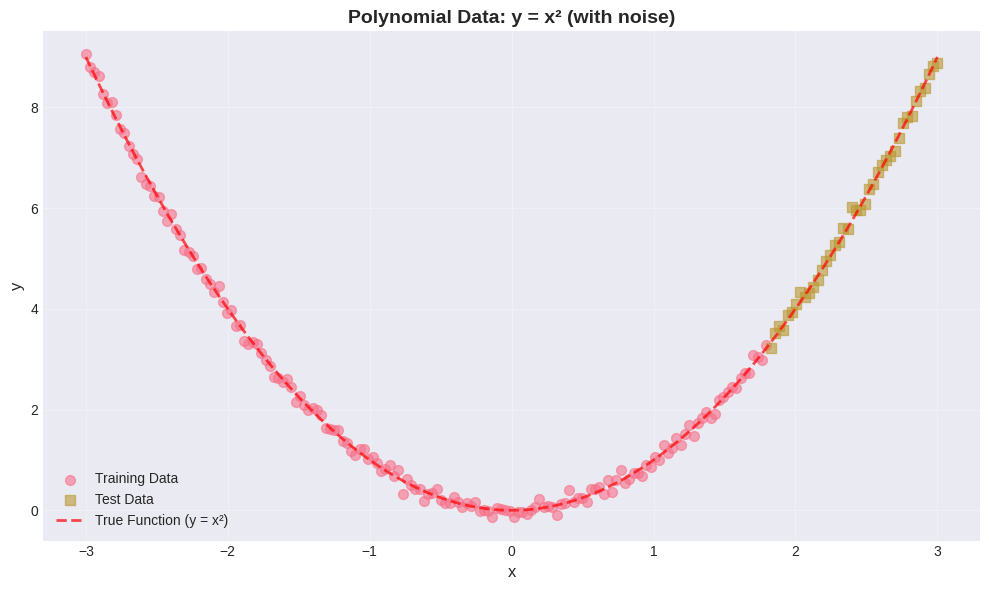

📊 Data visualization saved as 'polynomial_data.png'


In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.6, label='Training Data', s=50)
plt.scatter(X_test, y_test, alpha=0.6, label='Test Data', s=50, marker='s')

# Plot true parabola
x_smooth = np.linspace(INPUT_RANGE[0], INPUT_RANGE[1], 1000)
y_smooth = x_smooth ** 2
plt.plot(x_smooth, y_smooth, 'r--', linewidth=2, label='True Function (y = x²)', alpha=0.7)

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Polynomial Data: y = x² (with noise)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('polynomial_data.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Data visualization saved as 'polynomial_data.png'")

## 4. Data Normalization

Normalize data for stable training.

In [14]:
# Calculate normalization parameters from training data
X_mean, X_std = X_train.mean(), X_train.std()
y_mean, y_std = y_train.mean(), y_train.std()

# Normalize
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std
y_train_norm = (y_train - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std

print("✅ Data normalized successfully!")
print(f"  X: mean={X_mean:.3f}, std={X_std:.3f}")
print(f"  y: mean={y_mean:.3f}, std={y_std:.3f}")

✅ Data normalized successfully!
  X: mean=-0.603, std=1.393
  y: mean=2.296, std=2.413


NameError: name 'X_train_norm' is not defined

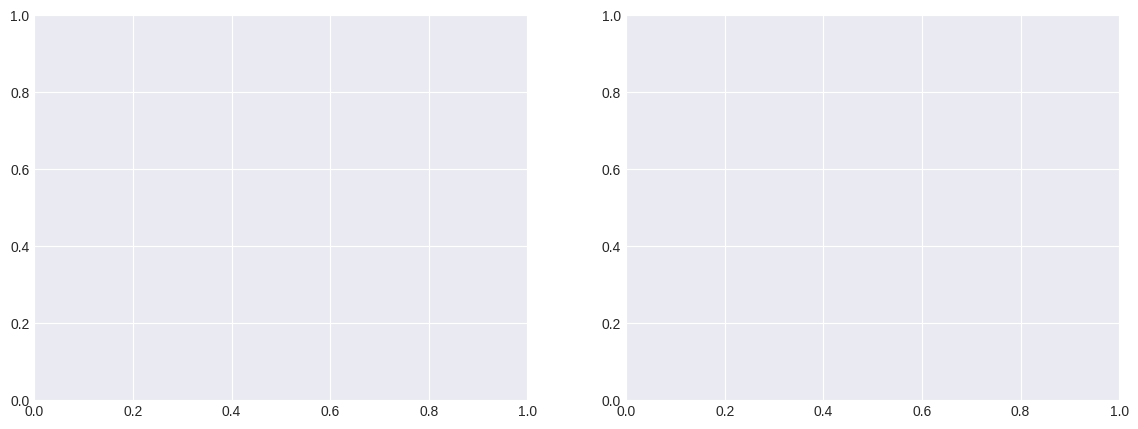

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Normalized vs Original X
axes[0].scatter(X_train, X_train_norm, alpha=0.6, s=50, label='Training Data')
axes[0].scatter(X_test, X_test_norm, alpha=0.6, s=50, marker='s', label='Test Data')
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Mean (0)')
axes[0].axhline(y=1, color='g', linestyle=':', linewidth=1, alpha=0.5, label='+1 std')
axes[0].axhline(y=-1, color='g', linestyle=':', linewidth=1, alpha=0.5, label='-1 std')
axes[0].set_xlabel('Original X', fontsize=12)
axes[0].set_ylabel('Normalized X', fontsize=12)
axes[0].set_title('Input Normalization', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Normalized vs Original y
axes[1].scatter(y_train, y_train_norm, alpha=0.6, s=50, label='Training Data')
axes[1].scatter(y_test, y_test_norm, alpha=0.6, s=50, marker='s', label='Test Data')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Mean (0)')
axes[1].axhline(y=1, color='g', linestyle=':', linewidth=1, alpha=0.5, label='+1 std')
axes[1].axhline(y=-1, color='g', linestyle=':', linewidth=1, alpha=0.5, label='-1 std')
axes[1].set_xlabel('Original y', fontsize=12)
axes[1].set_ylabel('Normalized y', fontsize=12)
axes[1].set_title('Output Normalization', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('normalized_data_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Normalized data visualization saved as 'normalized_data_comparison.png'")
print(f"\n📈 Normalization Statistics:")
print(f"  X_train_norm: mean={X_train_norm.mean():.6f}, std={X_train_norm.std():.6f}")
print(f"  y_train_norm: mean={y_train_norm.mean():.6f}, std={y_train_norm.std():.6f}")
print(f"  X_test_norm: mean={X_test_norm.mean():.6f}, std={X_test_norm.std():.6f}")
print(f"  y_test_norm: mean={y_test_norm.mean():.6f}, std={y_test_norm.std():.6f}")


## 5. Neural Network Implementation

### Architecture:
```
Input (1) → Hidden1 (1 + tanh) → Hidden2 (1 + tanh) → Output (1)
```

### Forward Propagation:
1. **Layer 1**: h1 = tanh(W1 · x + b1)
2. **Layer 2**: h2 = tanh(W2 · h1 + b2)
3. **Output**: y = W3 · h2 + b3

### Activation Function:
We use **tanh** (hyperbolic tangent) which outputs values in range [-1, 1]

In [ ]:
class TwoLayerNetwork:
    def __init__(self, learning_rate=0.01):
        """
        Initialize 2-layer neural network with 1 neuron in each hidden layer
        """
        self.lr = learning_rate
        
        # Initialize weights using Xavier initialization
        # Layer 1: Input (1) → Hidden1 (1)
        self.W1 = np.random.randn(1, 1) * np.sqrt(2.0 / 1)
        self.b1 = np.zeros((1, 1))
        
        # Layer 2: Hidden1 (1) → Hidden2 (1)
        self.W2 = np.random.randn(1, 1) * np.sqrt(2.0 / 1)
        self.b2 = np.zeros((1, 1))
        
        # Layer 3: Hidden2 (1) → Output (1)
        self.W3 = np.random.randn(1, 1) * np.sqrt(2.0 / 1)
        self.b3 = np.zeros((1, 1))
        
        # Store activations for backpropagation
        self.cache = {}
        
    def tanh(self, x):
        """Hyperbolic tangent activation"""
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        """Derivative of tanh: 1 - tanh²(x)"""
        return 1 - np.tanh(x) ** 2
    
    def forward(self, X):
        """
        Forward propagation through the network
        
        Args:
            X: Input data (n_samples, 1)
        
        Returns:
            y_pred: Predictions (n_samples, 1)
        """
        # Layer 1: Input → Hidden1
        self.cache['z1'] = X @ self.W1 + self.b1  # Linear transformation
        self.cache['h1'] = self.tanh(self.cache['z1'])  # Activation
        
        # Layer 2: Hidden1 → Hidden2
        self.cache['z2'] = self.cache['h1'] @ self.W2 + self.b2
        self.cache['h2'] = self.tanh(self.cache['z2'])
        
        # Layer 3: Hidden2 → Output (no activation)
        self.cache['z3'] = self.cache['h2'] @ self.W3 + self.b3
        y_pred = self.cache['z3']
        
        self.cache['X'] = X
        return y_pred
    
    def compute_loss(self, y_true, y_pred):
        """
        Compute Mean Squared Error loss
        """
        n = y_true.shape[0]
        loss = np.mean((y_pred - y_true) ** 2)
        return loss
    
    def backward(self, y_true, y_pred):
        """
        Backpropagation through the network
        
        Chain rule application:
        dL/dW3 = dL/dy_pred · dy_pred/dz3 · dz3/dW3
        dL/dW2 = dL/dy_pred · dy_pred/dz3 · dz3/dh2 · dh2/dz2 · dz2/dW2
        dL/dW1 = dL/dy_pred · dy_pred/dz3 · dz3/dh2 · dh2/dz2 · dz2/dh1 · dh1/dz1 · dz1/dW1
        """
        n = y_true.shape[0]
        
        # Output layer gradient
        # dL/dy_pred = 2(y_pred - y_true) / n
        dL_dy_pred = 2 * (y_pred - y_true) / n
        
        # Layer 3 gradients (Output layer)
        # dy_pred/dz3 = 1 (no activation)
        dL_dz3 = dL_dy_pred
        dL_dW3 = self.cache['h2'].T @ dL_dz3
        dL_db3 = np.sum(dL_dz3, axis=0, keepdims=True)
        
        # Layer 2 gradients (Hidden layer 2)
        # dz3/dh2 = W3
        dL_dh2 = dL_dz3 @ self.W3.T
        # dh2/dz2 = tanh'(z2)
        dL_dz2 = dL_dh2 * self.tanh_derivative(self.cache['z2'])
        dL_dW2 = self.cache['h1'].T @ dL_dz2
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        
        # Layer 1 gradients (Hidden layer 1)
        # dz2/dh1 = W2
        dL_dh1 = dL_dz2 @ self.W2.T
        # dh1/dz1 = tanh'(z1)
        dL_dz1 = dL_dh1 * self.tanh_derivative(self.cache['z1'])
        dL_dW1 = self.cache['X'].T @ dL_dz1
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
        
        # Store gradients
        self.gradients = {
            'dW1': dL_dW1, 'db1': dL_db1,
            'dW2': dL_dW2, 'db2': dL_db2,
            'dW3': dL_dW3, 'db3': dL_db3
        }
        
        return self.gradients
    
    def update_parameters(self):
        """
        Update parameters using gradient descent
        """
        self.W1 -= self.lr * self.gradients['dW1']
        self.b1 -= self.lr * self.gradients['db1']
        self.W2 -= self.lr * self.gradients['dW2']
        self.b2 -= self.lr * self.gradients['db2']
        self.W3 -= self.lr * self.gradients['dW3']
        self.b3 -= self.lr * self.gradients['db3']
    
    def get_parameters(self):
        """Return current parameters"""
        return {
            'W1': self.W1.copy(), 'b1': self.b1.copy(),
            'W2': self.W2.copy(), 'b2': self.b2.copy(),
            'W3': self.W3.copy(), 'b3': self.b3.copy()
        }

# Initialize network
model = TwoLayerNetwork(learning_rate=LEARNING_RATE)

print("✅ Neural network initialized!")
print(f"  Architecture: 1 → {HIDDEN1_SIZE} → {HIDDEN2_SIZE} → 1")
print(f"  Activation: tanh")
print(f"  Learning rate: {LEARNING_RATE}")
print("\n📊 Initial Parameters:")
params = model.get_parameters()
for name, value in params.items():
    print(f"  {name}: {value.flatten()}")

## 6. Setup TensorBoard and MLflow

In [ ]:
# Create log directories
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"logs/tensorboard/polynomial_{timestamp}"
os.makedirs(log_dir, exist_ok=True)

# TensorBoard writer
writer = tf.summary.create_file_writer(log_dir)

# MLflow setup
mlflow.set_experiment("Polynomial_Function_Approximation")
mlflow.start_run(run_name=f"2layer_polynomial_{timestamp}")

# Log hyperparameters
mlflow.log_params({
    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "hidden1_size": HIDDEN1_SIZE,
    "hidden2_size": HIDDEN2_SIZE,
    "activation": "tanh",
    "num_samples": NUM_SAMPLES,
    "noise_std": NOISE_STD
})

print("✅ TensorBoard and MLflow configured!")
print(f"  TensorBoard logs: {log_dir}")
print(f"  MLflow experiment: Polynomial_Function_Approximation")
print("\n💡 To view TensorBoard: tensorboard --logdir=logs/tensorboard")
print("💡 To view MLflow: mlflow ui")

## 7. Training Loop

In [ ]:
# Training history
history = {
    'train_loss': [],
    'test_loss': [],
    'W1': [], 'b1': [],
    'W2': [], 'b2': [],
    'W3': [], 'b3': [],
    'grad_W1': [], 'grad_W2': [], 'grad_W3': []
}

print("🚀 Starting training...\n")

for epoch in range(EPOCHS):
    # Forward pass
    y_pred_train = model.forward(X_train_norm)
    train_loss = model.compute_loss(y_train_norm, y_pred_train)
    
    # Backward pass
    gradients = model.backward(y_train_norm, y_pred_train)
    
    # Update parameters
    model.update_parameters()
    
    # Evaluate on test set
    y_pred_test = model.forward(X_test_norm)
    test_loss = model.compute_loss(y_test_norm, y_pred_test)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    
    params = model.get_parameters()
    history['W1'].append(params['W1'][0, 0])
    history['b1'].append(params['b1'][0, 0])
    history['W2'].append(params['W2'][0, 0])
    history['b2'].append(params['b2'][0, 0])
    history['W3'].append(params['W3'][0, 0])
    history['b3'].append(params['b3'][0, 0])
    
    history['grad_W1'].append(np.abs(gradients['dW1'][0, 0]))
    history['grad_W2'].append(np.abs(gradients['dW2'][0, 0]))
    history['grad_W3'].append(np.abs(gradients['dW3'][0, 0]))
    
    # Log to TensorBoard
    with writer.as_default():
        tf.summary.scalar('Loss/train', train_loss, step=epoch)
        tf.summary.scalar('Loss/test', test_loss, step=epoch)
        tf.summary.scalar('Parameters/W1', params['W1'][0, 0], step=epoch)
        tf.summary.scalar('Parameters/b1', params['b1'][0, 0], step=epoch)
        tf.summary.scalar('Parameters/W2', params['W2'][0, 0], step=epoch)
        tf.summary.scalar('Parameters/b2', params['b2'][0, 0], step=epoch)
        tf.summary.scalar('Parameters/W3', params['W3'][0, 0], step=epoch)
        tf.summary.scalar('Parameters/b3', params['b3'][0, 0], step=epoch)
        tf.summary.scalar('Gradients/W1', np.abs(gradients['dW1'][0, 0]), step=epoch)
        tf.summary.scalar('Gradients/W2', np.abs(gradients['dW2'][0, 0]), step=epoch)
        tf.summary.scalar('Gradients/W3', np.abs(gradients['dW3'][0, 0]), step=epoch)
    
    # Log to MLflow (every 100 epochs)
    if epoch % 100 == 0:
        mlflow.log_metrics({
            "train_loss": train_loss,
            "test_loss": test_loss
        }, step=epoch)
    
    # Print progress
    if (epoch + 1) % 200 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:4d}/{EPOCHS} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

print("\n✅ Training completed!")
print(f"  Final train loss: {history['train_loss'][-1]:.6f}")
print(f"  Final test loss: {history['test_loss'][-1]:.6f}")

## 8. Visualizations

### 8.1 Training Loss Curve

In [ ]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Log scale
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('polynomial_loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Loss curve saved as 'polynomial_loss_curve.png'")

### 8.2 Parameter Evolution

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Layer 1 parameters
axes[0, 0].plot(history['W1'], linewidth=2, color='blue')
axes[0, 0].set_title('Weight 1 (W1)', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

axes[1, 0].plot(history['b1'], linewidth=2, color='blue')
axes[1, 0].set_title('Bias 1 (b1)', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True, alpha=0.3)

# Layer 2 parameters
axes[0, 1].plot(history['W2'], linewidth=2, color='green')
axes[0, 1].set_title('Weight 2 (W2)', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].plot(history['b2'], linewidth=2, color='green')
axes[1, 1].set_title('Bias 2 (b2)', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Value')
axes[1, 1].grid(True, alpha=0.3)

# Output layer parameters
axes[0, 2].plot(history['W3'], linewidth=2, color='red')
axes[0, 2].set_title('Weight 3 (W3)', fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Value')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 2].plot(history['b3'], linewidth=2, color='red')
axes[1, 2].set_title('Bias 3 (b3)', fontweight='bold')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Value')
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Parameter Evolution During Training', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('polynomial_parameter_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Parameter evolution saved as 'polynomial_parameter_evolution.png'")

### 8.3 Gradient Magnitudes

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['grad_W1'], label='|∂L/∂W1|', linewidth=2)
plt.plot(history['grad_W2'], label='|∂L/∂W2|', linewidth=2)
plt.plot(history['grad_W3'], label='|∂L/∂W3|', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Gradient Magnitude', fontsize=12)
plt.title('Gradient Magnitudes', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['grad_W1'], label='|∂L/∂W1|', linewidth=2)
plt.plot(history['grad_W2'], label='|∂L/∂W2|', linewidth=2)
plt.plot(history['grad_W3'], label='|∂L/∂W3|', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Gradient Magnitude', fontsize=12)
plt.title('Gradient Magnitudes (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('polynomial_gradients.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Gradient magnitudes saved as 'polynomial_gradients.png'")

### 8.4 Final Predictions vs True Function

In [ ]:
# Generate predictions for smooth curve
x_plot = np.linspace(INPUT_RANGE[0], INPUT_RANGE[1], 1000).reshape(-1, 1)
x_plot_norm = (x_plot - X_mean) / X_std
y_plot_pred_norm = model.forward(x_plot_norm)
y_plot_pred = y_plot_pred_norm * y_std + y_mean

# True function
y_plot_true = x_plot ** 2

plt.figure(figsize=(12, 6))

# Plot data points
plt.scatter(X_train, y_train, alpha=0.5, s=50, label='Training Data', color='blue')
plt.scatter(X_test, y_test, alpha=0.5, s=50, label='Test Data', color='orange', marker='s')

# Plot true function
plt.plot(x_plot, y_plot_true, 'r--', linewidth=3, label='True Function (y = x²)', alpha=0.7)

# Plot predicted function
plt.plot(x_plot, y_plot_pred, 'g-', linewidth=3, label='Neural Network Prediction', alpha=0.8)

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Polynomial Function Approximation: Neural Network vs True Function', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('polynomial_final_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Final predictions saved as 'polynomial_final_predictions.png'")

## 9. Performance Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions on test set (denormalized)
y_pred_test_norm = model.forward(X_test_norm)
y_pred_test = y_pred_test_norm * y_std + y_mean

# Calculate metrics
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

# Mean Absolute Percentage Error
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n" + "="*50)
print("📊 PERFORMANCE METRICS (Test Set)")
print("="*50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error:   {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score:                  {r2:.4f}")
print(f"MAPE:                      {mape:.2f}%")
print("="*50)

# Log to MLflow
mlflow.log_metrics({
    "final_mse": mse,
    "final_rmse": rmse,
    "final_mae": mae,
    "final_r2": r2,
    "final_mape": mape
})

# Log final parameters
final_params = model.get_parameters()
print("\n📊 Final Network Parameters:")
for name, value in final_params.items():
    print(f"  {name}: {value.flatten()[0]:.6f}")
    mlflow.log_param(f"final_{name}", value.flatten()[0])

### Error Distribution

In [ ]:
errors = y_test - y_pred_test

plt.figure(figsize=(12, 5))

# Error histogram
plt.subplot(1, 2, 1)
plt.hist(errors, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Error Distribution', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test, errors, alpha=0.6, s=50)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('polynomial_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Error analysis saved as 'polynomial_error_analysis.png'")

## 10. Cleanup and Save

In [ ]:
# Close TensorBoard writer
writer.close()

# Log artifacts to MLflow
mlflow.log_artifact('polynomial_data.png')
mlflow.log_artifact('polynomial_loss_curve.png')
mlflow.log_artifact('polynomial_parameter_evolution.png')
mlflow.log_artifact('polynomial_gradients.png')
mlflow.log_artifact('polynomial_final_predictions.png')
mlflow.log_artifact('polynomial_error_analysis.png')

# End MLflow run
mlflow.end_run()

print("\n✅ All artifacts saved and logged!")
print("\n" + "="*50)
print("🎉 TRAINING COMPLETE!")
print("="*50)
print("\n📊 View results:")
print("  • TensorBoard: tensorboard --logdir=logs/tensorboard")
print("  • MLflow UI: mlflow ui")
print("  • Generated plots: Check current directory")

## 11. Key Takeaways

### What We Learned:

1. **Non-linear Approximation**: A 2-layer neural network can approximate quadratic functions (y = x²)

2. **Hidden Layer Role**: 
   - Layer 1 transforms input into intermediate representation
   - Layer 2 combines features to create final non-linear mapping

3. **Activation Functions**: tanh enables non-linear transformations essential for approximating curves

4. **Backpropagation**: Chain rule propagates gradients through multiple layers

5. **Training Dynamics**: 
   - Loss decreases as network learns the parabolic shape
   - Parameters converge to values that minimize prediction error
   - Gradients decrease as network approaches optimal solution

### Limitations:

- Small network (1 neuron per layer) limits approximation capacity
- May struggle with higher-degree polynomials (x³, x⁴, etc.)
- Extrapolation beyond training range may be unreliable

### Next Steps:

- Try more neurons per layer for better approximation
- Experiment with different activation functions (ReLU, sigmoid)
- Test on higher-degree polynomials
- Add more hidden layers for complex functions